In [1]:
from create_data_single import Circ as cc
from dgcnsuq import DGCN as cn
import matplotlib
import matplotlib.pyplot as plt

In [2]:
data_instance = cc(0.4, 0.4, 0.2, 26)
fpc, fnc, pc, lp, tc, lt = data_instance.create_dataset(10, 2, [100], [0.2], True, 10)

In [3]:
import torch
torch.manual_seed(26)
fpc, fnc, pc, lp, tc, lt = torch.tensor(fpc), torch.tensor(fnc), torch.tensor(pc), torch.tensor(lp), torch.tensor(tc), torch.tensor(lt)

In [4]:
pc.view(-1, pc.size(-1)).shape

torch.Size([560, 2])

In [5]:
training_data = pc.reshape(-1, pc.size(-1))
test_data = tc[0]
noise_var = 0.01
training_label = noise_var * torch.randn(training_data.size(0))
test_label = torch.Tensor(test_data.size(0))

In [6]:
training_data.shape

torch.Size([560, 2])

In [7]:
model = cn(training_data, test_data, training_label, test_label, False, 1, noise_var)

In [8]:
model.train_kernel(num_epochs=100, batch_size=20, learning_rate=0.0001, print_every=3)

C:\Users\Acer\Documents\All_of_RWTH\ThesisTarget\1MYWORK\thesis_notebooks\dgcnsuq.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3679.)
  dist_term = -0.5 * (label - mean).T @ torch.linalg.inv(variance) @ (label - mean)


Epoch:0, Loss: -13.370887688228063
Epoch:3, Loss: -16.454487090378763
Epoch:6, Loss: -20.890269260723425
Epoch:9, Loss: -23.17707752829479
Epoch:12, Loss: -24.094006916144078
Epoch:15, Loss: -24.342133123629473
Epoch:18, Loss: -24.407202389105688
Epoch:21, Loss: -24.445450918956517
Epoch:24, Loss: -24.467175227783457
Epoch:27, Loss: -24.4968550318502
Epoch:30, Loss: -24.517311350521727
Epoch:33, Loss: -24.531791780861518
Epoch:36, Loss: -24.546692957861534
Epoch:39, Loss: -24.542746555575604
Epoch:42, Loss: -24.552909486973785
Epoch:45, Loss: -24.55489072158534
Epoch:48, Loss: -24.55638036527601
Epoch:51, Loss: -24.559260996155153
Epoch:54, Loss: -24.56300348928207
Epoch:57, Loss: -24.56526491349826
Epoch:60, Loss: -24.5663670337592
Epoch:63, Loss: -24.571386679045954
Epoch:66, Loss: -24.574075077537476
Epoch:69, Loss: -24.564783426369786
Epoch:72, Loss: -24.576800282701203
Epoch:75, Loss: -24.579080890068386
Epoch:78, Loss: -24.57850016216162
Epoch:81, Loss: -24.582671652095055
Epoch:

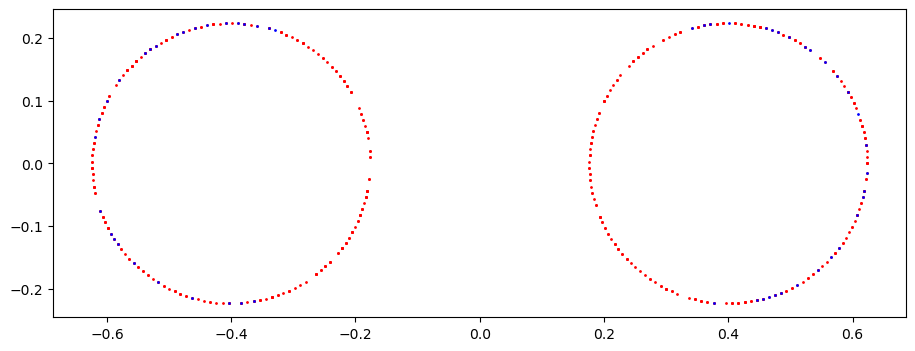

In [9]:
fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(111)
ax.scatter(training_data.cpu().numpy()[:, 0], training_data.cpu().numpy()[:, 1], c='r', s=1)
ax.scatter(test_data.cpu().numpy()[:, 0], test_data.cpu().numpy()[:, 1], c='b', s=1)

Text(0.5, 1.0, 'Probability of being on the surface')

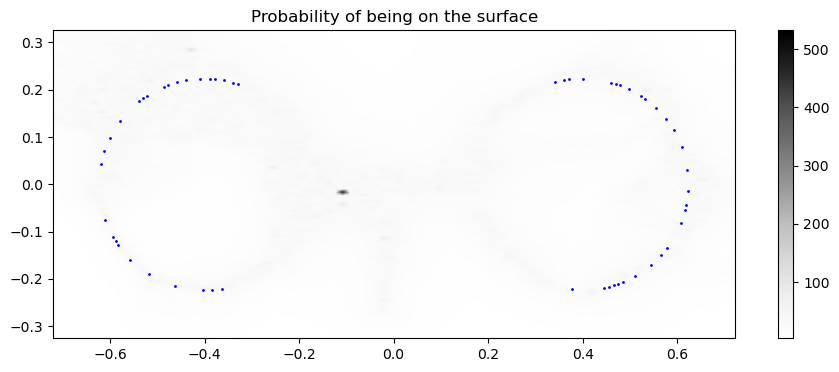

In [10]:
import numpy as np
from scipy.stats import norm
grid_sizes = np.ones(2, dtype=np.int32) * 100
def create_grid(box_min=None, box_max=None, eps=0.1):
    # find the bounding box for all dataset
    if box_min is None:
        box_min = torch.amin(test_data, 0) - eps
    if box_max is None:
        box_max = torch.amax(test_data, 0) + eps

    # Build a grid (dimension-agnostic)
    grid_vertices = np.meshgrid(
        *[np.linspace(box_min[d], box_max[d], grid_sizes[d]) for d in range(2)])
    grid_vertices = np.stack(grid_vertices, axis=-1).reshape(-1, 2)
    grid_vertices = torch.tensor(grid_vertices, dtype=torch.float32)
    return grid_vertices

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
grid_data = create_grid().to(device)
grid_label = torch.Tensor(grid_data.size(0)).to(device)
test_label = noise_var * torch.randn(test_data.size(0)).to(device)
pm, pv = model.compute_posterior_batch(test_data, test_label, grid_data, grid_label, True)
pd = torch.diagonal(pv, 0)
with torch.no_grad():
    prob_on_surface = norm.pdf(np.zeros(pm.shape), loc=pm.cpu().detach().numpy(),
                               scale=np.sqrt(pd.cpu().detach().numpy()))
gp = grid_data.cpu().numpy()
gp_x = gp[:, 0].reshape(grid_sizes)
gp_y = gp[:, 1].reshape(grid_sizes)
gp_prob = prob_on_surface.reshape(grid_sizes)

fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(111)
plot = ax.pcolormesh(gp_x, gp_y, gp_prob, shading='gouraud', cmap='Greys')
ax.scatter(test_data.cpu().numpy()[:, 0], test_data.cpu().numpy()[:, 1], c='b', s=1)
fig.colorbar(plot)
ax.axis('equal')
ax.set_title(f'Probability of being on the surface')